In [25]:
import logging
logging.getLogger().setLevel(logging.ERROR)
from pathlib import Path
from collections import defaultdict

import numpy as np
from scipy import stats
from tqdm import tqdm
from matplotlib import pyplot as plt

from docembedder.preprocessor.preprocessor import Preprocessor
from docembedder.analysis import get_model_correlations, classification_benchmark, compare_classification_similarity
from docembedder import BERTEmbedder, TfidfEmbedder, D2VEmbedder, BPembEmbedder

In [5]:
data_dir = Path("..", "data")
unprocessed_dir = data_dir / "unprocessed"

In [11]:
models = {
    "sberta": BERTEmbedder("AI-Growth-Lab/PatentSBERTa"),
    "tfidf": TfidfEmbedder(),
    "doc2vec": D2VEmbedder(),
}
prep_skips = [{}, {"keep_caps": True}, {"keep_start_section": True}, {"remove_non_alpha": True}]
prep_models = {}
for skips in prep_skips:
    if len(skips):
        skip_name = list(skips)[0]
    else:
        skip_name = "all"
    prep_models[skip_name] = Preprocessor(log_level=logging.ERROR, **skips)

[nltk_data] Downloading package punkt to /home/qubix/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [31]:
def classification_benchmark(patent_dicts, n_patent_sample, n_class_sample, start_year,
                             end_year):
    all_results = {}
    n_patents = len(patent_dicts["all"])
    sampled_idx = np.random.choice(n_patents, size=n_patent_sample, replace=False)

    for patents_name, patents in patent_dicts.items():
        documents = [p["contents"] for p in patents]
        sampled_patents = [patents[i] for i in sampled_idx]
        sampled_documents = [documents[i] for i in sampled_idx]
        model_cor: Dict[str, Any] = {}
        for model_name, model in models.items():
            model_cor[model_name] = get_model_correlations(model, documents, sampled_documents)

        results = compare_classification_similarity(sampled_patents, model_cor,
                                                    class_fp=Path("..", "data", "GPCPCs.txt"),
                                                    n_sample=n_class_sample)
        for model_name, res in results.items():
            combi_name = model_name + "-" + patents_name
            all_results[combi_name] = res

        
    return all_results       

In [35]:
%%time
all_results = defaultdict(lambda: [])
all_years = []
n_patent_sample = 200
n_class_sample = 5000
start_year, end_year = 1860, 1870

for fp in tqdm(list(unprocessed_dir.glob("*.xz"))):
    year = int(fp.stem)
    if year < start_year or year > end_year:
        continue
    patent_dicts = {
        prep_model_name: prep.preprocess_file(fp)[0] for prep_model_name, prep in prep_models.items()
    }
    if len(patent_dicts["all"]) < 100:
        continue
    results = classification_benchmark(patent_dicts, n_patent_sample, n_class_sample,
                                       start_year=start_year, end_year=end_year)

    all_years.append(year)
    for model_name, res in results.items():
        all_results[model_name].append(res)

100%|████████████████████████████████████████████████████████| 114/114 [50:14<00:00, 26.44s/it]

CPU times: user 1h 25min 50s, sys: 2min 11s, total: 1h 28min 1s
Wall time: 50min 14s


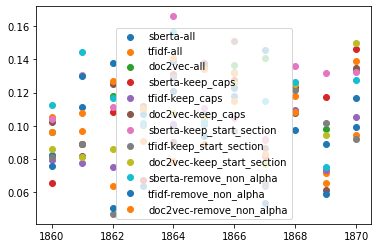

In [37]:
for model_name, res in all_results.items():
    plt.scatter(all_years, res, label=model_name)
plt.legend()
plt.show()

In [38]:
{name: np.mean(data) for name, data in all_results.items()}

{'sberta-all': 0.11181664858114723,
 'tfidf-all': 0.09803673762944327,
 'doc2vec-all': 0.11433935491672022,
 'sberta-keep_caps': 0.10551058021923314,
 'tfidf-keep_caps': 0.09288623465937285,
 'doc2vec-keep_caps': 0.1082720417364522,
 'sberta-keep_start_section': 0.12010838655941693,
 'tfidf-keep_start_section': 0.09476265039103518,
 'doc2vec-keep_start_section': 0.10439533184988886,
 'sberta-remove_non_alpha': 0.11919550599982721,
 'tfidf-remove_non_alpha': 0.09183286343037689,
 'doc2vec-remove_non_alpha': 0.1074824353979257}